In [1]:
#READ EXCEL AND CSV DATA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#READ all source csc/xlsx files into dataframes 

#from kaggle
flights_df_path = "C:\\_ML Projects\\CapStone Data\\flight-delays\\flights.csv"
airports_df_path = "C:\\_ML Projects\\CapStone Data\\flight-delays\\airports.csv"
airlines_df_path = "C:\\_ML Projects\\CapStone Data\\flight-delays\\airlines.csv"

#my personal list of info 
ap_df_path = "C:\\_ML Projects\\CapStone Data\\Airport Operations Counts\\airport info.xlsx"

#custom reports using FAA-available websites
ap_ops_df_path = "C:\\_ML Projects\\CapStone Data\\Airport Operations Counts\\2015 airport ops.xlsx"
reg_ops_df_path = "C:\\_ML Projects\\CapStone Data\\Airport Operations Counts\\2015 region ops.xlsx"


flights_df = pd.read_csv(flights_df_path, dtype={"ORIGIN_AIRPORT": np.str, "DESTINATION_AIRPORT": np.str}) #, index_col = 0)
airports_df = pd.read_csv(airports_df_path)
airlines_df = pd.read_csv(airlines_df_path)

ap_df = pd.read_excel(ap_df_path, sheet_name='Airports', dtype={"AirportID":np.str, "StateID": np.str, "Region" : np.str})
ap_df = ap_df[(ap_df['AirportID'] != 'nan') & (ap_df['AirportID'] != '0')]
ap_df = ap_df[['AirportID', 'StateID', 'Region']]

ap_ops_df = pd.read_excel(ap_ops_df_path, sheet_name='Airport Ops')
reg_ops_df = pd.read_excel(reg_ops_df_path, sheet_name='Region Ops')

#look at first rows
#flights_df.head(10)
#print(ap_df.columns)
#print(ap_df.shape)
#print(ap_df.head(10))

In [2]:
#GLOBALLY SHARED METHODS

import math
import numpy as np

def CheckIfNullOrEmpty(myValue):
    
    retValue = 0
    
    if type(myValue) == float:
        if math.isnan(myValue):
            retValue = 1
    elif type(myValue) != str:
        if myValue == None:
            retValue = 1
    elif myValue == None:
        retValue = 1
    elif len(myValue.strip()) == 0:
        retValue = 1
    elif pd.isnull(myValue):
        retValue = 1
    elif type(myValue) == str and myValue.strip() == 'nan':
        retValue = 1
    else:
        retValue = 0
        
    return retValue 


def CheckIfMissing(mySeries):
    
    result = mySeries.apply(CheckIfNullOrEmpty).sum()
    
    return result



def CheckRow(mySeries):
    
    
    sumValue = mySeries.apply(CheckIfNullOrEmpty).sum()
    
    if sumValue >= 1:
        retValue = False
    else:
        retValue = True
        
    return retValue 


def IsDataPresent(myValue):
    
    retValue = True
    
    if type(myValue) == float:
        if math.isnan(myValue):
            retValue = False
    elif type(myValue) != str:
        if myValue == None:
            retValue = False
    elif myValue == None:
        retValue = False
    elif len(myValue.strip()) == 0:
        retValue = False
    elif pd.isnull(myValue):
        retValue = False
    elif type(myValue) == str and myValue.strip() == 'nan':
        retValue = False
    else:
        retValue = True
        
    return retValue 





def APCategory(value):

    if value < mid:
        result = 'MID'
    else:
         result = 'SMALL'
       
    return result 



def PredictThreshold(model, Xtestlr, threshold):
    
    prob = model.predict_proba(Xtestlr)[:,1]
    
    predictions = np.where(prob >= threshold, 1, 0)
    
    return predictions


In [3]:
#replace some column null values in flight data
#FILTER OUT cancelled or diverted flights

flights_df['CANCELLATION_REASON'] = flights_df['CANCELLATION_REASON'].fillna('Not Provided')
flights_df.loc[:, ['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']] = flights_df.loc[:, ['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']].fillna(0) 

#don't include canceled or flights diverted to another airport
active_flights_df = flights_df[flights_df.CANCELLED  != 1]
active_flights_df = active_flights_df[active_flights_df.DIVERTED != 1]

In [4]:
#REMOVE DATA COLUMNS THAT WONT INCLUDE IN THE ANALYSIS

#flightdata_df = active_flights_df.drop(columns={
#    'FLIGHT_NUMBER', 'TAIL_NUMBER', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
#'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN'}, inplace=False)

#keeping only first 1000 rows while in test mode. remove that restraint later
flightdata_df = active_flights_df[['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT','DESTINATION_AIRPORT',
                               'DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'DISTANCE']]    
#[0:1000]

airports_df = airports_df[['IATA_CODE', 'CITY','STATE']]
ap_df = airports_df.rename(columns={'IATA_CODE':'AirportID', 'CITY':'CityID','STATE':'StateID'}, inplace=False)

airlines_df = airlines_df[['IATA_CODE']]
airln_df = airlines_df.rename(columns={'IATA_CODE':'AirlineID'}, inplace=False)

ap_ops_df = ap_ops_df[['Facility', 'TotalOperations']]
ap_oper_df = ap_ops_df.rename(columns={'Facility':'AirportID', 'TotalOperations':'TotalOps'}, inplace=False)



In [5]:
#remove missing flight data
#dataframe.isnull().sum()

emptylist_df = flightdata_df.apply(CheckIfMissing, axis=0)
print('check if any missing data in result_df\n', emptylist_df)
print(flightdata_df.shape)

flights_df_nonempty = flightdata_df[flightdata_df.apply(CheckRow, axis=1)] 
emptylist_df = flights_df_nonempty.apply(CheckIfMissing, axis=0)
print('check if any missing data in result_df\n', emptylist_df)
print(flights_df_nonempty.shape)

check if any missing data in result_df
 MONTH                  0
DAY                    0
DAY_OF_WEEK            0
AIRLINE                0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
DEPARTURE_DELAY        0
ARRIVAL_DELAY          0
DISTANCE               0
dtype: int64
(5714008, 9)
check if any missing data in result_df
 MONTH                  0
DAY                    0
DAY_OF_WEEK            0
AIRLINE                0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
DEPARTURE_DELAY        0
ARRIVAL_DELAY          0
DISTANCE               0
dtype: int64
(5714008, 9)


In [6]:
#REMOVE BOGUS AIRPORT INFO FLIGHT DATA ROWS
#get rid of numbered airports (conveniently they all start with the number 1 instead of a letter)
print(flights_df_nonempty.shape)
flights2_df = flights_df_nonempty[flights_df_nonempty['ORIGIN_AIRPORT'].astype(str).str[0] != '1']
print(flights2_df.shape)
flights2_df = flights2_df[flights2_df['ORIGIN_AIRPORT'].astype(str).str[0] != '1']
print(flights2_df.shape)



(5714008, 9)
(5231130, 9)
(5231130, 9)


In [7]:
##remove missing airport data
#print(airports_df.iloc[0:10, 0:16])
#print(airports_df.iloc[0:10, 16:-1])


emptylist_df = ap_df.apply(CheckIfMissing, axis=0)
print('check if any missing data in result_df\n', emptylist_df)
print(ap_df.shape)

airports_df_nonempty = ap_df[ap_df.apply(CheckRow, axis=1)] 
emptylist_df = airports_df_nonempty.apply(CheckIfMissing, axis=0)
print('check if any missing data in result_df\n', emptylist_df)
print(airports_df_nonempty.shape)

check if any missing data in result_df
 AirportID    0
CityID       0
StateID      0
dtype: int64
(322, 3)
check if any missing data in result_df
 AirportID    0
CityID       0
StateID      0
dtype: int64
(322, 3)


In [8]:
#REMOVE AIRLINES MISSING DATA

emptylist_df = airln_df.apply(CheckIfMissing, axis=0)
print('check if any missing data in result_df\n', emptylist_df)
print(airln_df.shape)

airlines_df_nonempty = airln_df[airln_df.apply(CheckRow, axis=1)] 
emptylist_df = airlines_df_nonempty.apply(CheckIfMissing, axis=0)
print('check if any missing data in result_df\n', emptylist_df)
print(airlines_df_nonempty.shape)

check if any missing data in result_df
 AirlineID    0
dtype: int64
(14, 1)
check if any missing data in result_df
 AirlineID    0
dtype: int64
(14, 1)


In [9]:
#REMOVE AIRPORT OPS MISSING DATA

emptylist_df = ap_oper_df.apply(CheckIfMissing, axis=0)
print('check if any missing data in result_df\n', emptylist_df)
print(ap_oper_df.shape)

ap_ops_df_nonempty = ap_oper_df[ap_oper_df.apply(CheckRow, axis=1)] 
emptylist_df = ap_ops_df_nonempty.apply(CheckIfMissing, axis=0)
print('check if any missing data in result_df\n', emptylist_df)
print(ap_ops_df_nonempty.shape)


check if any missing data in result_df
 AirportID    0
TotalOps     0
dtype: int64
(517, 2)
check if any missing data in result_df
 AirportID    0
TotalOps     0
dtype: int64
(517, 2)


In [10]:
#JOIN data sets together

flights2_df
ap_ops_df_nonempty


#result_df = pd.merge(flights2_df,
#                 airports_df_nonempty[['AirportID', 'StateID']],
#                 left_on = 'ORIGIN_AIRPORT', right_on='AirportID', 
#                 how='right').rename(columns={'StateID':'Origin_State'})
                 
#result_df = pd.merge(result_df,
#                 airports_df_nonempty[['AirportID', 'StateID']],
#                 left_on = 'DESTINATION_AIRPORT', right_on='AirportID', 
#                 how='right').rename(columns={'StateID':'Destination_State'})


result_df = pd.merge(flights2_df,
                 ap_ops_df_nonempty[['AirportID', 'TotalOps']],
                 left_on = 'ORIGIN_AIRPORT', right_on='AirportID', 
                 how='inner').rename(columns={'TotalOps':'TotalOps_OriginAirport'})

result_df.drop(columns=['AirportID','ORIGIN_AIRPORT'], inplace=True)

result_df = pd.merge(result_df,
                 ap_ops_df_nonempty[['AirportID', 'TotalOps']],
                 left_on = 'DESTINATION_AIRPORT', right_on='AirportID', 
                 how='inner').rename(columns={'TotalOps':'TotalOps_DestinationAirport'})

result_df.drop(columns=['AirportID','DESTINATION_AIRPORT'], inplace=True)


#result_df['late'] = result_df['ARRIVAL_DELAY'] > 0 

result_df.loc[ result_df['ARRIVAL_DELAY'] > 0, 'late'] = 1
result_df.loc[ result_df['ARRIVAL_DELAY'] <= 0, 'late'] = 0

#flights_df.loc[ flights_df['DEPARTURE_DELAY'] == 0, 'late'] = 'On Time'
#flights_df.loc[ flights_df['DEPARTURE_DELAY'] > 0, 'late'] = 'Late'

#result_df = pd.merge(result_df,
#                 ap_ops_df_nonempty[['Facility', 'TotalOperations']],
#                 left_on = 'DESTINATION_AIRPORT', right_on='Facility', 
#                 how='right').rename(columns={'TotalOperations':'TotalOperations_DestinationAirport'})

#result_df['TotalOperations_OriginAirport'] = result_df['TotalOperations_OriginAirport'].astype(int)


In [11]:
#note - try the library that Jeff recommended instead of this

result_df2 = pd.get_dummies(result_df['AIRLINE']) #,prefix=['AL_'])

result_df3 = pd.concat([result_df, result_df2], axis = 1)

In [12]:
result_df3.head(3)

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,DEPARTURE_DELAY,ARRIVAL_DELAY,DISTANCE,TotalOps_OriginAirport,TotalOps_DestinationAirport,late,...,EV,F9,HA,MQ,NK,OO,UA,US,VX,WN
0,1,1,4,AS,-11.0,-22.0,1448,278684,381408,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,4,AS,-4.0,-14.0,1448,278684,381408,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,4,DL,-14.0,-24.0,1448,278684,381408,0.0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
#result_df.dtypes


#result_df = result_df[result_df['ORIGIN_AIRPORT'].astype(str).str[0] != '1']
result_df3[['late']] = result_df3[['late']].astype(int)
result_df3.dtypes
result_df3.head(3)
#result_df3


#result_df.shape #(1320, 11)
#flights2_df.shape #(1000,9)
#airports_df_nonempty.shape #(322,3)



#emptylist_df = flights2_df.apply(CheckIfMissing, axis=0)
#print('check if any missing data in result_df\n', emptylist_df)
#print(flights2_df.shape)

#test_df = flights2_df[flights2_df.apply(CheckRow, axis=1)] 
#emptylist_df = test_df.apply(CheckIfMissing, axis=0)
#print('check if any missing data in result_df\n', emptylist_df)
#print(test_df.shape)



,MONTH,DAY,DAY_OF_WEEK,AIRLINE,DEPARTURE_DELAY,ARRIVAL_DELAY,DISTANCE,TotalOps_OriginAirport,TotalOps_DestinationAirport,late,...,EV,F9,HA,MQ,NK,OO,UA,US,VX,WN
0,1,1,4,AS,-11.0,-22.0,1448,278684,381408,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,4,AS,-4.0,-14.0,1448,278684,381408,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,4,DL,-14.0,-24.0,1448,278684,381408,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
#result_df3.where(result_df3[['late']] == 1)
#result_df4 = result_df3.loc[result_df3['late'] == 1]
#result_df3

#result_df4.groupby('AIRLINE')['AIRLINE'].count()


result_df4 = result_df3.loc[result_df3['late'] == 1].groupby('AIRLINE')['AIRLINE'].count()
result_df4
#If you wanted to add frequency back to the original dataframe use transform to return an aligned index:
#df['freq'] = df.groupby('a')['a'].transform('count')

AIRLINE
AA    229350
AS     46973
B6     93303
DL    233943
EV    189703
F9     38569
HA     27826
MQ     95927
NK     52338
OO    188537
UA    174320
US     76285
VX     22244
WN    440052
Name: AIRLINE, dtype: int64

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report



In [16]:
#split data input with the intent of predicting 'late'
#random_state - the seed used by the random number generator
# test_size is auto set to 0.25 since it wasn't defined

#data_df = result_df.drop(columns={'AIRLINE'}, inplace=True)

# Split the data into a training and test set.
#Xlr, Xtestlr, ylr, ytestlr = train_test_split(result_df[['TotalOps_OriginAirport','TotalOps_DestinationAirport']], 
#                                              result_df.late, random_state=5)
Xlr, Xtestlr, ylr, ytestlr = train_test_split(result_df3[['TotalOps_OriginAirport','TotalOps_DestinationAirport','AA','DL','EV','OO','UA','WN']], 
                                              result_df3.late, random_state=5)

In [17]:
Xlr.shape
ylr.shape

(3844582,)

In [18]:
clf = LogisticRegression()
# Fit the model on the training data.
clf.fit(Xlr, ylr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [19]:
# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(Xtestlr), ytestlr))

0.6278879587492431


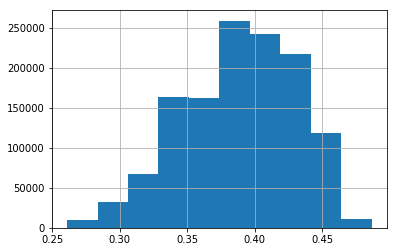

In [20]:
pd.Series(clf.predict_proba(Xtestlr)[:,1]).hist() #shows our predictions

In [21]:
#y_pred = clf.predict(Xtestlr)
#y_pred
#Xtestlr

#y_pred = clf.predict([[379376, 314616]])

#y_pred
#ytestlr
#Xtestlr

df = Xtestlr
df = clf.predict(Xtestlr)
df

array([0, 0, 0, ..., 0, 0, 0])

In [22]:
predictions = PredictThreshold(clf, Xtestlr, 0.4)

print(accuracy_score(predictions, ytestlr))

predictions

#precision in recall 

0.521086546684895


array([1, 1, 1, ..., 0, 1, 0])

In [23]:
print(classification_report(predictions, ytestlr))

#can sample

             precision    recall  f1-score   support

          0       0.58      0.63      0.60    737317
          1       0.43      0.37      0.40    544211

avg / total       0.51      0.52      0.52   1281528



In [24]:
#RANDOM FORESTS

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import numpy as np


C:\Users\wrgorman\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [25]:
#number of trees in the forest
n_estimators = [10, 50, 100]
#the function used to measure the quality of a split.
criterion = ['gini', 'entropy']

print(n_estimators)
print(np.ravel(n_estimators))
print(np.reshape(n_estimators, (-1,)))
print(np.reshape(n_estimators, (1, -1)))

n_estimators = np.reshape(n_estimators, (-1,))
n_estimators = np.ravel(n_estimators)

print(criterion)

param_grid = {'n_estimators':n_estimators, 'criterion':criterion}

rfc = RandomForestClassifier()

GSCV_rfc = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 5)

[10, 50, 100]
[ 10  50 100]
[ 10  50 100]
[[ 10  50 100]]
['gini', 'entropy']


In [31]:
from datetime import date

X = result_df3.drop(['late'], axis = 1)
X = X.drop(['AIRLINE', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY'], axis = 1)
Y = result_df3[['late']]




#print(X.head())
#print(Y.head())

print(date.today())
#GSCV_rfc.fit(X,Y) #a column vector was passed when a 1d array was expected. please shange shape of y to (n_samples,) using ravel()
GSCV_rfc.fit(X,np.ravel(Y)) #NOTE that this takes hours to run
print(GSCV_rfc.best_params_)
print(date.today())

2019-09-17
{'criterion': 'gini', 'n_estimators': 100}
2019-09-17


In [32]:
#split data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 100, test_size = 0.3, train_size = 0.7)

In [33]:
from sklearn.metrics import accuracy_score

y_predict = GSCV_rfc.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_predict))

print("Report:", classification_report(y_test, y_predict))

Accuracy: 0.7967145977489103
Report:              precision    recall  f1-score   support

          0       0.81      0.88      0.84    965555
          1       0.76      0.66      0.71    572278

avg / total       0.79      0.80      0.79   1537833



In [37]:
#peek inside the random forest model to see what had the greatest influences

importances = GSCV_rfc.best_estimator_.feature_importances_
#print(importances)

forest = GSCV_rfc.best_estimator_.estimators_
#print(forest)

print('tree count', len(GSCV_rfc.best_estimator_.estimators_))
print('feature importances', len(importances))
print('features', len(X.columns))

tree count 100
feature importances 20
features 20


In [38]:
std = np.std([tree.feature_importances_ for tree in forest], axis=0)
indices = np.argsort(importances)[::-1]
print("feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

feature ranking:
1. feature 3 (0.253824)
2. feature 1 (0.209196)
3. feature 5 (0.183626)
4. feature 4 (0.162310)
5. feature 0 (0.092314)
6. feature 2 (0.063695)
7. feature 9 (0.007001)
8. feature 19 (0.003230)
9. feature 16 (0.002829)
10. feature 15 (0.002825)
11. feature 14 (0.002603)
12. feature 10 (0.002510)
13. feature 6 (0.002398)
14. feature 13 (0.002261)
15. feature 8 (0.002227)
16. feature 11 (0.001817)
17. feature 7 (0.001681)
18. feature 17 (0.001357)
19. feature 18 (0.001255)
20. feature 12 (0.001041)


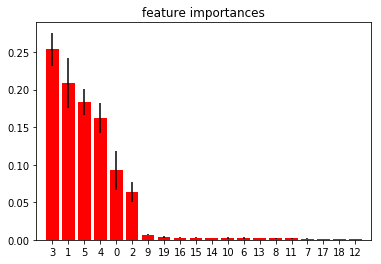

In [39]:
#plot the feature importances of the forest
plt.figure()
plt.title("feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [40]:
X.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'DISTANCE', 'TotalOps_OriginAirport',
       'TotalOps_DestinationAirport', 'AA', 'AS', 'B6', 'DL', 'EV', 'F9', 'HA',
       'MQ', 'NK', 'OO', 'UA', 'US', 'VX', 'WN'],
      dtype='object')

In [ ]:
#IGNORE BELOW

In [3]:
#FILTER OUT cancelled or diverted flights 

#flights_df.head(10)
#desc = flights_df.describe()
#desc.iloc[:,0:5]
#flights_df.shape # (5819079, 31)

print('flights shape:', flights_df.shape) 
print('airports shape:', airports_df.shape)
print('airlines shape:', airlines_df.shape)
print('airport info shape:', ap_df.shape)
print('airport ops shape:', ap_ops_df.shape)
print('region ops shape:', reg_ops_df.shape) # (3607, 10)




flights_df['CANCELLATION_REASON'] = flights_df['CANCELLATION_REASON'].fillna('Not Provided')
flights_df.loc[:, ['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']] = flights_df.loc[:, ['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']] .fillna(0) 

#don't include canceled or flights diverted to another airport
active_flights_df = flights_df[flights_df.CANCELLED  != 1]
active_flights_df = active_flights_df[active_flights_df.DIVERTED != 1]

#print(active_flights_df.iloc[0:3, 0:16])
#print(active_flights_df.iloc[0:3, 16:-1])


#below is not relevant. just saved experiments


#flights_df.loc[:, ['AIR_SYSTEM_DELAY' , 'LATE_AIRCRAFT_DELAY']]
#flights_df.loc[:, 'AIR_SYSTEM_DELAY' : 'LATE_AIRCRAFT_DELAY'].fillna(0, inplace = True) #i found that .loc wont support inplace

#flights_df.loc[:, 'AIR_SYSTEM_DELAY' : 'LATE_AIRCRAFT_DELAY'] = flights_df.loc[:, 'AIR_SYSTEM_DELAY' : 'LATE_AIRCRAFT_DELAY'].fillna(0)  
#flights_df.loc[:, 'AIR_SYSTEM_DELAY' : 'LATE_AIRCRAFT_DELAY'] = flights_df.loc[:, 'AIR_SYSTEM_DELAY' : 'LATE_AIRCRAFT_DELAY'].fillna(0)  
#flights_df['CANCELLATION_REASON'] = flights_df['CANCELLATION_REASON'].fillna('Not Provided')
#flights_df[['CANCELLATION_REASON']] = flights_df[['CANCELLATION_REASON']].fillna('Not Provided')


#flights_df.loc[ap_df['AirportName'].isnull() == True, :]# ['AirportName']

flights shape: (5819079, 31)
airports shape: (322, 7)
airlines shape: (14, 2)
airport info shape: (3607, 10)
airport ops shape: (517, 8)
region ops shape: (9, 8)


In [78]:


airports_df = pd.read_csv(airports_df_path)


#ap_df = pd.read_excel(ap_df_path, sheet_name='Airports')
#ap_df = ap_df[ap_df.AirportID.notnull()]

print(airports_df.iloc[0:10, 0:16])
print(airports_df.iloc[0:10, 16:30])
print(airports_df.iloc[0:10, 30:-1])

emptylist_df = airports_df.apply(CheckIfMissing, axis=0)
print('check if any missing data in result_df\n', emptylist_df)
print(airports_df.shape)

test_df = airports_df[airports_df.apply(CheckRow, axis=1)] 
emptylist_df = test_df.apply(CheckIfMissing, axis=0)
print('check if any missing data in result_df\n', emptylist_df)
print(test_df.shape)

#def my_filter(row):
#    if row.columnA == something:
#        return True

#    return False

#if len(df.index) > 0:
#    df[df.apply(my_filter, axis=1)]


  IATA_CODE                              AIRPORT           CITY STATE COUNTRY  \
0       ABE  Lehigh Valley International Airport      Allentown    PA     USA   
1       ABI             Abilene Regional Airport        Abilene    TX     USA   
2       ABQ    Albuquerque International Sunport    Albuquerque    NM     USA   
3       ABR            Aberdeen Regional Airport       Aberdeen    SD     USA   
4       ABY   Southwest Georgia Regional Airport         Albany    GA     USA   
5       ACK           Nantucket Memorial Airport      Nantucket    MA     USA   
6       ACT                Waco Regional Airport           Waco    TX     USA   
7       ACV                       Arcata Airport  Arcata/Eureka    CA     USA   
8       ACY  Atlantic City International Airport  Atlantic City    NJ     USA   
9       ADK                         Adak Airport           Adak    AK     USA   

   LATITUDE  LONGITUDE  
0  40.65236  -75.44040  
1  32.41132  -99.68190  
2  35.04022 -106.60919  
3  45.44

In [4]:
#JOIN data sets together

result_df = pd.merge(active_flights_df,
                 ap_df[['AirportID', 'StateID', 'Region']],
                 left_on = 'ORIGIN_AIRPORT', right_on='AirportID', 
                 how='left').rename(columns={'Region':'Origin_Region', 'StateID':'Origin_State'})

result_df = pd.merge(result_df,
                 ap_df[['AirportID', 'StateID', 'Region']],
                 left_on = 'DESTINATION_AIRPORT', right_on='AirportID', 
                 how='left', suffixes=('_Origin', '_Destination')).rename(columns={'Region':'Destination_Region', 'StateID':'Destination_State'})

result_df = pd.merge(result_df,
                 airports_df[['IATA_CODE', 'LATITUDE', 'LONGITUDE']],
                 left_on = 'AirportID_Origin', right_on='IATA_CODE', 
                 how='left').rename(columns={'LATITUDE':'lat_origin', 'LONGITUDE':'long_origin'})

result_df = pd.merge(result_df,
                 airports_df[['IATA_CODE', 'LATITUDE', 'LONGITUDE']],
                 left_on = 'AirportID_Destination', right_on='IATA_CODE', 
                 how='left').rename(columns={'LATITUDE':'lat_destination', 'LONGITUDE':'long_destination'})

result_df = pd.merge(result_df,
                 ap_ops_df[['Facility', 'TotalOperations']],
                 left_on = 'AirportID_Origin', right_on='Facility', 
                 how='left').rename(columns={'TotalOperations':'TotalOperations_OriginAirport'})

result_df = pd.merge(result_df,
                 ap_ops_df[['Facility', 'TotalOperations']],
                 left_on = 'AirportID_Destination', right_on='Facility', 
                 how='left').rename(columns={'TotalOperations':'TotalOperations_DestinationAirport'})

result_df = pd.merge(result_df,
                 reg_ops_df[['Region', 'TotalOperations']],
                 left_on = 'Origin_Region', right_on='Region', 
                 how='left').rename(columns={'TotalOperations':'TotalOperations_OriginRegion'})

result_df = pd.merge(result_df,
                 reg_ops_df[['Region', 'TotalOperations']],
                 left_on = 'Destination_Region', right_on='Region', 
                 how='left').rename(columns={'TotalOperations':'TotalOperations_DestinationRegion'})




In [34]:
emptylist_df = result_df.apply(CheckIfMissing, axis=0)
print('check if any missing data in result_df\n', emptylist_df)

#result_df['Region_y'].apply(CheckIfNullOrEmpty)


check if any missing data in result_df
 YEAR                                        0
MONTH                                       0
DAY                                         0
DAY_OF_WEEK                                 0
AIRLINE                                     0
FLIGHT_NUMBER                               0
TAIL_NUMBER                                 0
ORIGIN_AIRPORT                              0
DESTINATION_AIRPORT                         0
SCHEDULED_DEPARTURE                         0
DEPARTURE_TIME                              0
DEPARTURE_DELAY                             0
TAXI_OUT                                    0
WHEELS_OFF                                  0
SCHEDULED_TIME                              0
ELAPSED_TIME                                0
AIR_TIME                                    0
DISTANCE                                    0
WHEELS_ON                                   0
TAXI_IN                                     0
SCHEDULED_ARRIVAL                       

In [14]:
mid = ap_ops_df['TotalOperations'].max() / 2

result2_df = result_df


#result2_df['OriginAirportCat'] = result_df['TotalOperations_OriginAirport'].apply(APCategory)
result2_df['OriginAirportCat']= result_df['TotalOperations_OriginAirport'].apply(APCategory)
result2_df['DestinationAirportCat']= result2_df['TotalOperations_DestinationAirport'].apply(APCategory)
        


print(result2_df.iloc[0:3, 0:16])
print(result2_df.iloc[0:3, 16:30])
print(result2_df.iloc[0:3, 30:-1])

#print(result2_df[['YEAR','OriginAirportCat']])

result2_df.head(100)


emptylist_df = result2_df.apply(CheckIfMissing, axis=0)
print('check if any missing data in result_df\n', emptylist_df)


   YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      1    1            4      AS             98      N407AS   
1  2015      1    1            4      AA           2336      N3KUAA   
2  2015      1    1            4      US            840      N171US   

  ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  DEPARTURE_TIME  \
0            ANC                 SEA                    5          2354.0   
1            LAX                 PBI                   10             2.0   
2            SFO                 CLT                   20            18.0   

   DEPARTURE_DELAY  TAXI_OUT  WHEELS_OFF  SCHEDULED_TIME  ELAPSED_TIME  
0            -11.0      21.0        15.0           205.0         194.0  
1             -8.0      12.0        14.0           280.0         279.0  
2             -2.0      16.0        34.0           286.0         293.0  
   AIR_TIME  DISTANCE  WHEELS_ON  TAXI_IN  SCHEDULED_ARRIVAL  ARRIVAL_TIME  \
0     169.0      1448      404.0    

In [3]:

#CELLS BELOW - DON'T EXECUTE. MOVE RELEVANT INFO TO ABOVE CELLS


active_flights_df['ORIGIN_AIRPORT'].unique()

#get rid of numbered airports (all start with 1)
test_df = active_flights_df[active_flights_df['ORIGIN_AIRPORT'].astype(str).str[0] != '1']


test_df['ORIGIN_AIRPORT'].unique()


test_df = pd.get_dummies(test_df['ORIGIN_AIRPORT'],prefix=['origin'])

test_df.head()



,['origin']_ABE,['origin']_ABI,['origin']_ABQ,['origin']_ABR,['origin']_ABY,['origin']_ACK,['origin']_ACT,['origin']_ACV,['origin']_ACY,['origin']_ADK,...,['origin']_TYS,['origin']_UST,['origin']_VEL,['origin']_VLD,['origin']_VPS,['origin']_WRG,['origin']_WYS,['origin']_XNA,['origin']_YAK,['origin']_YUM
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
print('active_flights_df shape:', active_flights_df.shape) 

#Checking for missing data
NAs = pd.concat([active_flights_df.isnull().sum()], axis=1)
missing = NAs[NAs.sum(axis=1) > 0]
print(missing)



active_flights_df shape: (5714008, 31)
Empty DataFrame
Columns: [0]
Index: []


In [9]:
def CheckIfNullOrEmpty(myValue):
    
    retValue = 0
    
    if type(myValue) != str:
        if myValue == None:
            retValue = 1
    elif myValue == None:
        retValue = 1
    elif len(myValue.strip()) == 0:
        retValue = 1
    else:
        retValue = 0
        
    return retValue 




def CheckIfMissing(mySeries):
    
    result = mySeries.apply(CheckIfNullOrEmpty).sum()
    
    return result





In [10]:
# initialize list of lists 
#data = [['tom', 10], ['nick', 15], ['juli', 14], ['doug', ''], ['cedric', None], [None, 34]] 
  
# Create the pandas DataFrame 
#df = pd.DataFrame(data, columns = ['Name', 'Age']) 
  
# print dataframe. 
#result_df = df.apply(CheckIfMissing, axis=0)
result_df = active_flights_df.apply(CheckIfMissing, axis=0)
print('check if any missing data in active flights \n', result_df)


check if any missing data in active flights 
 YEAR                   0
MONTH                  0
DAY                    0
DAY_OF_WEEK            0
AIRLINE                0
FLIGHT_NUMBER          0
TAIL_NUMBER            0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
DEPARTURE_TIME         0
DEPARTURE_DELAY        0
TAXI_OUT               0
WHEELS_OFF             0
SCHEDULED_TIME         0
ELAPSED_TIME           0
AIR_TIME               0
DISTANCE               0
WHEELS_ON              0
TAXI_IN                0
SCHEDULED_ARRIVAL      0
ARRIVAL_TIME           0
ARRIVAL_DELAY          0
DIVERTED               0
CANCELLED              0
CANCELLATION_REASON    0
AIR_SYSTEM_DELAY       0
SECURITY_DELAY         0
AIRLINE_DELAY          0
LATE_AIRCRAFT_DELAY    0
WEATHER_DELAY          0
dtype: int64


In [11]:
result_df = airlines_df.apply(CheckIfMissing, axis=0)
print('check if any missing data in airlines_df\n', result_df)

result_df = airports_df.apply(CheckIfMissing, axis=0)
print('check if any missing data in airports_df\n', result_df)

result_df = ap_df.apply(CheckIfMissing, axis=0)
print('check if any missing data in ap_df\n', result_df)

result_df = ap_ops_df.apply(CheckIfMissing, axis=0)
print('check if any missing data in ap_ops_df\n', result_df)

result_df = reg_ops_df.apply(CheckIfMissing, axis=0)
print('check if any missing data in reg_ops_df\n', result_df)


check if any missing data in airlines_df
 IATA_CODE    0
AIRLINE      0
dtype: int64
check if any missing data in airports_df
 IATA_CODE    0
AIRPORT      0
CITY         0
STATE        0
COUNTRY      0
LATITUDE     0
LONGITUDE    0
dtype: int64
check if any missing data in ap_df
 ID                      0
AirportID               0
ICAOID                  0
PDFFIle                 0
AirportName             0
AirportDiagramNumber    0
City                    0
StateID                 0
CFRPart139              0
Region                  0
dtype: int64
check if any missing data in ap_ops_df
 Facility             0
AirCarrier           0
AirTaxi              0
GeneralAviation      0
ItinerantMilitary    0
Civil                0
LocalMilitary        0
TotalOperations      0
dtype: int64
check if any missing data in reg_ops_df
 Region               0
AirCarrier           0
AirTaxi              0
GeneralAviation      0
ItinerantMilitary    0
Civil                0
LocalMilitary        0
TotalOp

In [12]:
#ap_df.columns[0:]
#ap_df.describe() # just gives stats on numeric cols. not strings 

#ap_df.isnull()

test_df = active_flights_df.loc[active_flights_df['ARRIVAL_TIME'].isnull() == True, :]# ['AirportName']
#test_df = active_flights_df.loc[CheckIfNullOrEmpty(active_flights_df['ARRIVAL_TIME']) == True, :]# ['AirportName']
#df['data'].apply(lambda x: 'true' if x <= 2.5 else 'false')

print(test_df.iloc[0:3, 0:16])
print(test_df.iloc[0:3, 16:-1])

#active_flights_df.loc[CheckIfNullOrEmpty(active_flights_df['ARRIVAL_TIME']) == True, :]

Empty DataFrame
Columns: [YEAR, MONTH, DAY, DAY_OF_WEEK, AIRLINE, FLIGHT_NUMBER, TAIL_NUMBER, ORIGIN_AIRPORT, DESTINATION_AIRPORT, SCHEDULED_DEPARTURE, DEPARTURE_TIME, DEPARTURE_DELAY, TAXI_OUT, WHEELS_OFF, SCHEDULED_TIME, ELAPSED_TIME]
Index: []
Empty DataFrame
Columns: [AIR_TIME, DISTANCE, WHEELS_ON, TAXI_IN, SCHEDULED_ARRIVAL, ARRIVAL_TIME, ARRIVAL_DELAY, DIVERTED, CANCELLED, CANCELLATION_REASON, AIR_SYSTEM_DELAY, SECURITY_DELAY, AIRLINE_DELAY, LATE_AIRCRAFT_DELAY]
Index: []


In [13]:
#flights_df.shape # (5819079, 32)
#flights_df.describe()
#flights_df.head(100)
#ap_df.head(100)

#flights_df.columns
#ap_df.columns

#df.columns = ['country','year','population','continent','life_exp','gdp_per_cap']


#gapminder.rename(columns={'pop':'population', 'lifeExp':'life_exp', 'gdpPercap':'gdp_per_cap'}, inplace=True)


#ap_df.groupby('AirportID')['AirportID'].count() #.size()



#ap_df.groupby('AirportID')['AirportID'].filter(lambda m:len(m) > 1)


result_df = pd.merge(active_flights_df,
                 ap_df[['AirportID', 'StateID', 'Region']],
                 left_on = 'ORIGIN_AIRPORT', right_on='AirportID', 
                 how='left').rename(columns={'Region':'Origin_Region', 'StateID':'Origin_State'})

result_df = pd.merge(result_df,
                 ap_df[['AirportID', 'StateID', 'Region']],
                 left_on = 'DESTINATION_AIRPORT', right_on='AirportID', 
                 how='left', suffixes=('_Origin', '_Destination')).rename(columns={'Region':'Destination_Region', 'StateID':'Destination_State'})

result_df = pd.merge(result_df,
                 airports_df[['IATA_CODE', 'LATITUDE', 'LONGITUDE']],
                 left_on = 'AirportID_Origin', right_on='IATA_CODE', 
                 how='left').rename(columns={'LATITUDE':'lat_origin', 'LONGITUDE':'long_origin'})

result_df = pd.merge(result_df,
                 airports_df[['IATA_CODE', 'LATITUDE', 'LONGITUDE']],
                 left_on = 'AirportID_Destination', right_on='IATA_CODE', 
                 how='left').rename(columns={'LATITUDE':'lat_destination', 'LONGITUDE':'long_destination'})

result_df = pd.merge(result_df,
                 ap_ops_df[['Facility', 'TotalOperations']],
                 left_on = 'AirportID_Origin', right_on='Facility', 
                 how='left').rename(columns={'TotalOperations':'TotalOperations_OriginAirport'})

result_df = pd.merge(result_df,
                 ap_ops_df[['Facility', 'TotalOperations']],
                 left_on = 'AirportID_Destination', right_on='Facility', 
                 how='left').rename(columns={'TotalOperations':'TotalOperations_DestinationAirport'})

result_df = pd.merge(result_df,
                 reg_ops_df[['Region', 'TotalOperations']],
                 left_on = 'Origin_Region', right_on='Region', 
                 how='left').rename(columns={'TotalOperations':'TotalOperations_OriginRegion'})

result_df = pd.merge(result_df,
                 reg_ops_df[['Region', 'TotalOperations']],
                 left_on = 'Destination_Region', right_on='Region', 
                 how='left').rename(columns={'TotalOperations':'TotalOperations_DestinationRegion'})


emptylist_df = result_df.apply(CheckIfMissing, axis=0)
print('check if any missing data in result_df\n', emptylist_df)


check if any missing data in result_df
 YEAR                                  0
MONTH                                 0
DAY                                   0
DAY_OF_WEEK                           0
AIRLINE                               0
FLIGHT_NUMBER                         0
TAIL_NUMBER                           0
ORIGIN_AIRPORT                        0
DESTINATION_AIRPORT                   0
SCHEDULED_DEPARTURE                   0
DEPARTURE_TIME                        0
DEPARTURE_DELAY                       0
TAXI_OUT                              0
WHEELS_OFF                            0
SCHEDULED_TIME                        0
ELAPSED_TIME                          0
AIR_TIME                              0
DISTANCE                              0
WHEELS_ON                             0
TAXI_IN                               0
SCHEDULED_ARRIVAL                     0
ARRIVAL_TIME                          0
ARRIVAL_DELAY                         0
DIVERTED                              0


In [20]:
#one hot encoding
result_df['ORIGIN_AIRPORT'].unique()

#test_df = pd.get_dummies(result_df['ORIGIN_AIRPORT'],prefix=['origin'])

#test_df.head(10)

array(['ANC', 'LAX', 'SFO', 'SEA', 'LAS', 'DEN', 'SLC', 'PDX', 'FAI',
       'MSP', 'PHX', 'SJU', 'PBG', 'IAG', 'PSE', 'BQN', 'ORD', 'GEG',
       'HNL', 'ONT', 'MCO', 'BOS', 'HIB', 'ABR', 'MAF', 'DFW', 'MKE',
       'IAH', 'BNA', 'BRO', 'VPS', 'BOI', 'BJI', 'SGF', 'PHL', 'SBN',
       'RDD', 'EUG', 'IAD', 'BUF', 'PWM', 'JFK', 'CRP', 'PIA', 'FAT',
       'SMF', 'AUS', 'MCI', 'ATL', 'JAX', 'MFR', 'IDA', 'MSN', 'DCA',
       'SAT', 'CHS', 'SBA', 'SMX', 'IND', 'CLE', 'GSP', 'BDL', 'ABI',
       'RIC', 'BFL', 'OMA', 'RDM', 'FLL', 'CID', 'TPA', 'SYR', 'ROC',
       'TYR', 'LAN', 'XNA', 'GSO', 'EWR', 'PBI', 'RSW', 'OAK', 'PVD',
       'RNO', 'PIT', 'ABQ', 'MIA', 'BWI', 'LGA', 'TUL', 'LIT', 'MSY',
       'OKC', 'ATW', 'PNS', 'MEM', 'TYS', 'MHT', 'SAV', 'CLT', 'GRB',
       'ABE', 'JAN', 'OAJ', 'FAR', 'ERI', 'LEX', 'CWA', 'MSO', 'TTN',
       'AMA', 'CLL', 'HOU', 'JLN', 'MLI', 'RDU', 'CVG', 'MHK', 'MOB',
       'TLH', 'BHM', 'CAE', 'TXK', 'ACY', 'DTW', 'RAP', 'TUS', 'EAU',
       'DLH', 'FSD',

In [11]:
#look at first row
#flights_df.head(1)
#flights_df.info()
#flights_df.describe(include="all").T

#flights_df[0:] # 5819079 rows × 31 columns


#len(flights_df) # 5819079

#flights_df.columns #names of the columns
#len(flights_df.columns) # 31

In [12]:
def IsStringEmpty(dfStringValue):
    result = (pd.isna(dfStringValue) == True)  |  (dfStringValue.str.strip() == '') 
    return result


#flights_df[0:10]

#flights_df.iloc[0:10,0:5]

#flights_df.loc[0:10,'YEAR':'AIRLINE']

#flights_df[flights_df['AIRLINE'] == 'AA'][0:10]

flights_df[pd.isna(flights_df['YEAR'])]

flights_df[pd.isnull(flights_df['YEAR'])]

#df['A1'].fillna('')


flights_df[pd.isna(flights_df['YEAR'])]

#(C or (flights_df['ORIGIN_AIRPORT'].str.strip() == '')

flights_df[flights_df['ORIGIN_AIRPORT'].str.strip() == '']

flights_df[pd.isna(flights_df['ORIGIN_AIRPORT']) == True]

flights_df[   (pd.isna(flights_df['ORIGIN_AIRPORT']) == True)  |  (flights_df['ORIGIN_AIRPORT'].str.strip() == '') ]

flights_df[IsStringEmpty(flights_df['ORIGIN_AIRPORT'])]



#for i, j in df.iterrows(): 
#    print(i, j) 
#    print()


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY


In [13]:
def IsStringEmpty(dfStringValue):
    if type(dfStringValue) == str:
        result = False #result = (pd.isna(dfStringValue) == True)  |  (dfStringValue.str.strip() == '') 
    else:
        result = True
        
    print(result)
    
    return result

# type(flights_df.columns) # pandas.core.indexes.base.Index
#list(flights_df.columns)
#flights_df.columns.values.tolist()
#sorted(flights_df.columns)

for col in flights_df.columns: 
    #print(flights_df[IsStringEmpty(flights_df[col])]) 
    
    IsStringEmpty(flights_df[col])

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [14]:
#for index, row in flights_df[0:10].iterrows(): 
#    print(index, row) 
#    print()
    
    
#flights_df['EarlyOrLate'] = flights_df['DEPARTURE_DELAY'] < 0


#for index, row in flights_df[0:10].iterrows(): 
#    print(index, row) 
#    print()
    
    
# df['elderly'] = np.where(df['age']>=50, 'yes', 'no')


#df.loc[df['A'] == df['B'], 'C'] = 0
#df.loc[df['A'] > df['B'], 'C'] = 1
#df.loc[df['A'] < df['B'], 'C'] = -1



flights_df.loc[ flights_df['DEPARTURE_DELAY'] < 0, 'MyStatus'] = 'Early'
flights_df.loc[ flights_df['DEPARTURE_DELAY'] == 0, 'MyStatus'] = 'On Time'
flights_df.loc[ flights_df['DEPARTURE_DELAY'] > 0, 'MyStatus'] = 'Late'


flights_df['MyStatus']


0            Early
1            Early
2            Early
3            Early
4            Early
5            Early
6            Early
7             Late
8            Early
9             Late
10           Early
11           Early
12         On Time
13           Early
14           Early
15           Early
16           Early
17           Early
18           Early
19           Early
20            Late
21           Early
22           Early
23           Early
24           Early
25           Early
26           Early
27            Late
28           Early
29            Late
            ...   
5819049       Late
5819050       Late
5819051       Late
5819052      Early
5819053    On Time
5819054      Early
5819055      Early
5819056      Early
5819057       Late
5819058      Early
5819059      Early
5819060      Early
5819061      Early
5819062       Late
5819063       Late
5819064      Early
5819065      Early
5819066      Early
5819067      Early
5819068      Early
5819069       Late
5819070    O